# Hourly Grocery Store Transactions - Principle Component Analysis

In [45]:
import pandas as pd
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect('data/SQL_Wedge.db')

# Query to load data from the view
query = """
            SELECT CAST(hour AS FLOAT) as hour, 
                  CAST(spend AS FLOAT) as spend, 
                  trans, 
                  CAST(items AS FLOAT) as items
           FROM date_hour
        """

# Load data into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()





In [46]:
# Not used for this analysis
# Pivot the data to create a matrix of owners x items
pivot_df = df.pivot_table(
    index='trans',     # Each unique transaction ID becomes a row
    columns='items',   # Each unique item becomes a column
    values='spend',    # The cell values are filled with spending amounts
    fill_value=0      # Empty cells are filled with 0
    
)

In [109]:


# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Perform PCA
pca = PCA()

pca.fit(scaled_data)



PCA()

In [110]:
x_pca = pca.transform(scaled_data)



In [111]:
scaled_data.shape
x_pca.shape

(38838, 4)

In [112]:
explained_variance = pca.explained_variance_ratio_[0]
print(f"Amount of variance explained for PC1: {explained_variance:.4f}")



Amount of variance explained for PC1: 0.7230


In [114]:
cumulative_variance = 0
for i in range(len(pca.explained_variance_ratio_)):
    explained_variance = pca.explained_variance_ratio_[i]
    cumulative_variance += explained_variance
    print(f"Amount of variance explained for PC{i + 1}: {explained_variance:.4f}% | Cumulative: {cumulative_variance:.2f}%")
    
    if cumulative_variance > .95:
        break
    

Amount of variance explained for PC1: 0.7230% | Cumulative: 0.72%
Amount of variance explained for PC2: 0.2480% | Cumulative: 0.97%


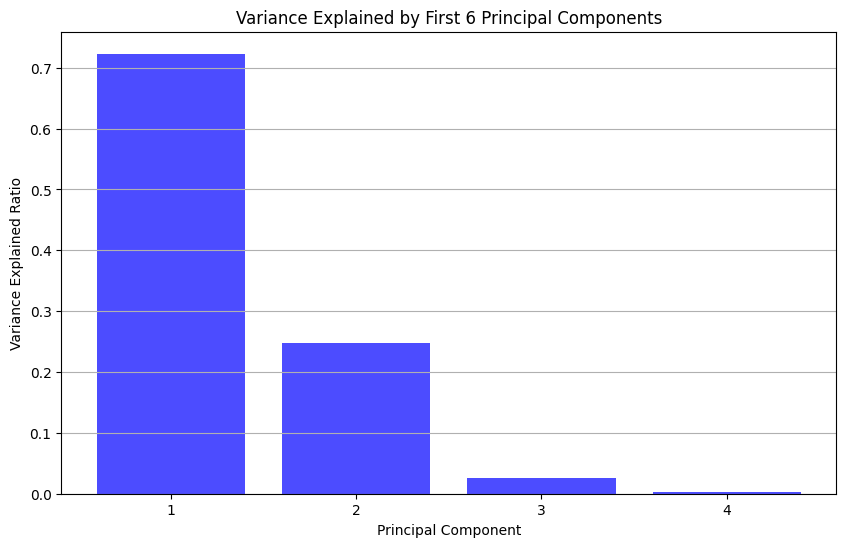

In [126]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, 5), pca.explained_variance_ratio_[:4], alpha=0.7, color='blue')
plt.title('Variance Explained by First 6 Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained Ratio')
plt.xticks(range(1, 5))
plt.grid(axis='y')
plt.show()

Text(0, 0.5, 'Principle Component 2')

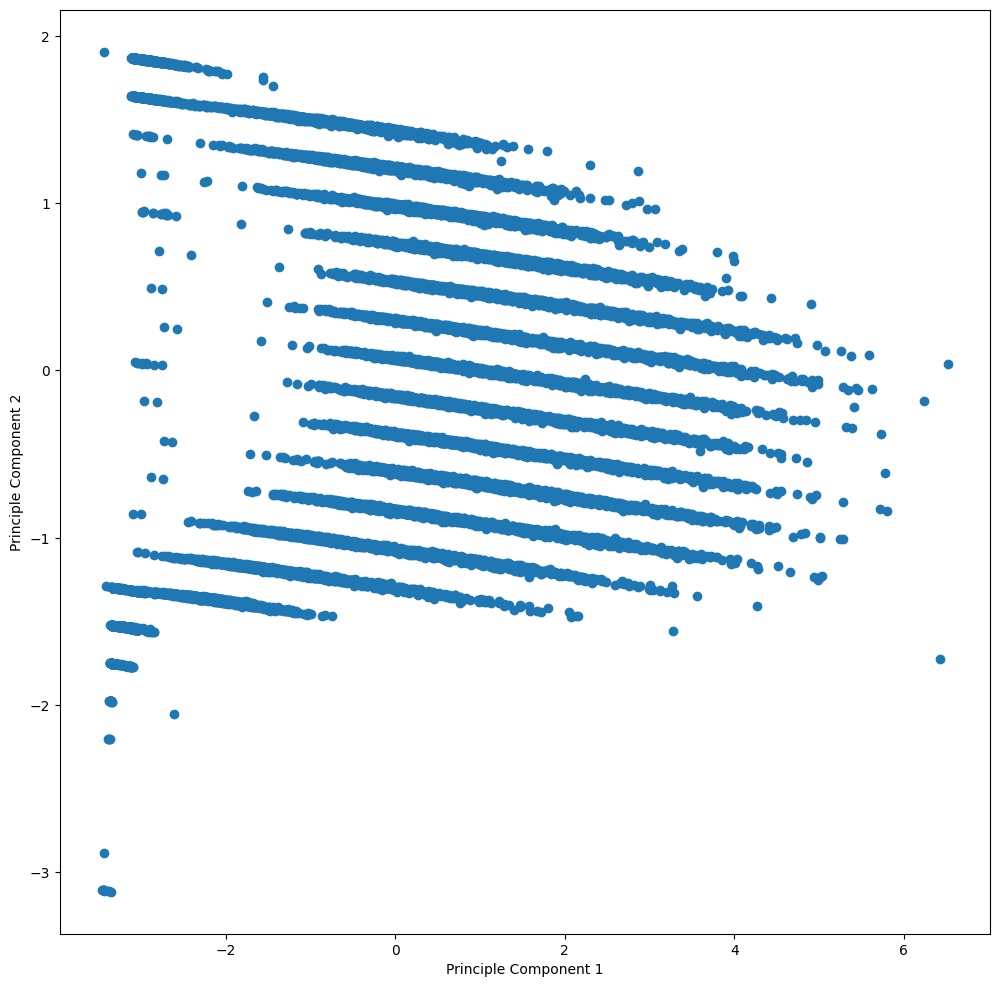

In [127]:
plt.figure(figsize=(12,12))
plt.scatter(x_pca[:,0], x_pca[:,1] )
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")

In [ ]:
pca.components_

In [ ]:
comp = pd.DataFrame(pca.components_, columns=df['hour'])

In [ ]:
# Create a DataFrame with PC1 scores and transaction IDs
pc1_df = pd.DataFrame({
    'PC1_Score': pca_result[:, 0],  # First PC
    'PC2_Score': pca_result[:, 1],  # Second PC
    'Transaction_ID': pivot_df.index
})

# Sort by PC1 score to see the extremes
pc1_df_sorted = pc1_df.sort_values('PC1_Score')



plt.figure(figsize=(10, 6))
plt.scatter(pc1_df['PC1_Score'], pc1_df['PC2_Score'], alpha=0.5)
plt.title('Scatter Plot of Transactions on First Two Principal Components')
plt.xlabel('PC1 Score')
plt.ylabel('PC2 Score')
plt.grid(True)
plt.show()
high_pc1 = pc1_df_sorted.tail(5)
print(pivot_df.loc[high_pc1.Transaction_ID])

print("\nTransactions with Lowest PC1 Scores (Bottom 5):")
low_pc1 = pc1_df_sorted.head(5)
print(pivot_df.loc[low_pc1.Transaction_ID])

# Identify Influential Transactions 

In [131]:

# Create a DataFrame with PC1 scores and transaction IDs
pc1_analysis = pd.DataFrame({
    'number_of_transactions': df.index,
    
    'pc1_score': x_pca[:,0],
    'pc2_score': x_pca[:,1]
})

# Look at extreme cases (most influential transactions)
print("Most extreme transactions by PC1:")
print(pc1_analysis.nlargest(5, 'pc1_score'))
print("\nMost negative transactions by PC1:")
print(pc1_analysis.nsmallest(5, 'pc1_score'))

Most extreme transactions by PC1:
       number_of_transactions  pc1_score  pc2_score
27639                   27639   6.518070   0.037576
9031                     9031   6.435322  -1.727095
10798                   10798   6.235922  -0.181087
14820                   14820   5.800770  -0.838489
16266                   16266   5.777770  -0.610327

Most negative transactions by PC1:
       number_of_transactions  pc1_score  pc2_score
20588                   20588  -3.464475  -3.106122
16869                   16869  -3.453658  -3.107097
18686                   18686  -3.453658  -3.107097
17927                   17927  -3.447224  -3.107776
22560                   22560  -3.446688  -3.107643


# Feature Importance
See which original features (items) contribute most to PC1.

Large loadings (positive or negative) indicate that a particular variable strongly relates to a particular principal component. 


In [132]:
pc1_loadings = pd.DataFrame(
    {'Total Items': df.columns,
     'loading': pca.components_[0]  # First principal component
    }).sort_values('loading', ascending=False)

# Show top contributing items
print("Top 10 items contributing to PC1:")
print(pc1_loadings.head(10))

Top 10 items contributing to PC1:
  Total Items   loading
3       items  0.581305
1       spend  0.579313
2       trans  0.567169
0        hour  0.069289


# Clustering Analysis

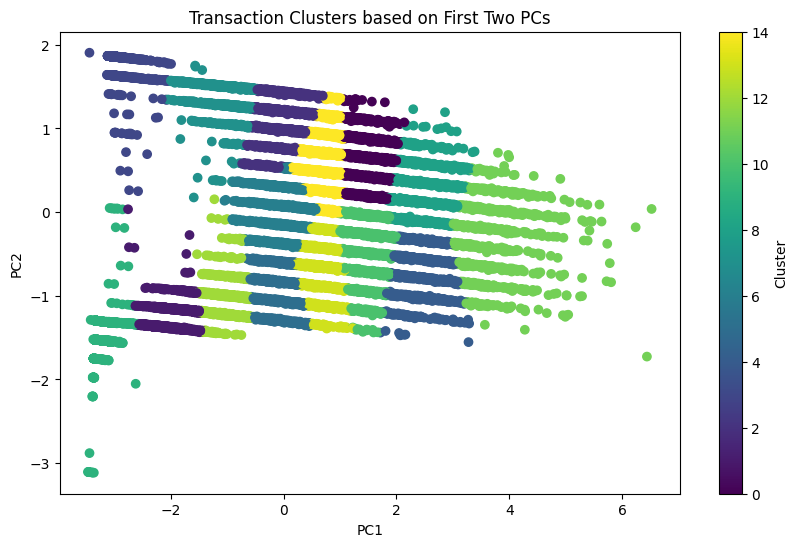

In [149]:
from sklearn.cluster import KMeans

# Use first few PCs for clustering
k = 15  # number of clusters
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(x_pca[:, :2])  # Using PC1 and PC2

# Visualize clusters
plt.figure(figsize=(10, 6))
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=clusters, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Transaction Clusters based on First Two PCs')
plt.colorbar(label='Cluster')
plt.show()

In [143]:
# Adjusting the scope to target Clusters that have PC 1 and 2 values greater than 1.
# Create a DataFrame with PC1 scores and transaction IDs
pc1_analysis = pd.DataFrame({
    'number_of_transactions': df.index,
    
    'pc1_score': x_pca[:,0],
    'pc2_score': x_pca[:,1]
})

# Apply filters for PC1 > 25 and PC2 > -9
filtered_pc1_analysis = pc1_analysis[
    (pc1_analysis['pc1_score'] > 0) &
    #(pc1_analysis['pc1_score'] < 25) &
    #(pc1_analysis['pc2_score'] < 13) &
    (pc1_analysis['pc2_score'] > 0)
]

# Look at extreme cases (most influential transactions)
print("Most extreme transactions by PC1:")
print(filtered_pc1_analysis.nlargest(10, 'pc1_score'))


Most extreme transactions by PC1:
       number_of_transactions  pc1_score  pc2_score
27639                   27639   6.518070   0.037576
4606                     4606   5.594477   0.090153
26639                   26639   5.380074   0.087750
15026                   15026   5.255910   0.114986
21699                   21699   5.067223   0.119071
16061                   16061   4.973584   0.149345
9652                     9652   4.901950   0.397171
23415                   23415   4.741484   0.165207
37430                   37430   4.716079   0.194211
6678                     6678   4.620583   0.185862
